# Imports & Consts

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import UnidentifiedImageError, Image
from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [2]:
DATA_FOLDER = "airbus-ship-detection/train_v2/"
OUTPUT_MASK_FILE = "airbus-ship-detection/train_ship_segmentations_v2.csv"
NEW_OUTPUT_MASK_FILE = "airbus-ship-detection/reduced_train_ship_segmentations_v2.csv"
IMAGE_SHAPE = (768, 768, 1)
np.random.seed(42)

# Image Folder Analysis

In [ ]:
unique_sizes = set()
for filename in os.listdir(DATA_FOLDER):
    image_path = os.path.join(DATA_FOLDER, filename)
    try:
        image = plt.imread(image_path)
        height, width, _ = image.shape
        unique_sizes.add((height, width))
    except UnidentifiedImageError and OSError:
        print(f"Image {image_path} can't be processed.")

In [188]:
unique_sizes

{(768, 768)}

Thus, we can set one constant image size for all images. Here, we also define the list of image ids we couldn't process.

In [27]:
unprocessed_images = ['f77a6c662.jpg', 
                      'f776f4f96.jpg', 
                      'f78062140.jpg', 
                      'f783072fd.jpg',
                      'f7780c42a.jpg',
                      '6384c3e78.jpg',
                      'f77b35e19.jpg',
                      'f7780c56f.jpg',
                      'f77788c23.jpg',
                      'f7835f914.jpg',
                      'f73c5d372.jpg',
                      'f73d393b3.jpg']

# EDA

Let us at first take a look at segmentation masks file.

In [28]:
mask = pd.read_csv(OUTPUT_MASK_FILE)
mask.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

We will replace `Nan` values with empty strings. Also, let us remove rows with images that haven't been processed.

In [29]:
mask['EncodedPixels'] = mask['EncodedPixels'].fillna('')
filter_mask = ~mask['ImageId'].isin(unprocessed_images)
mask = mask[filter_mask]

In [30]:
mask.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                   
1  0001124c7.jpg                                                   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

As one may notice, segmentation mask is presented in run-length encoding (RLE) which should be interpreted as following: by parsing the string with pairs (x, y) it means that starting from pixel #x (from top-left corner, reading from left to right and from top to bottom) we have y active pixels in mask (including #x). As an output, UNet takes image format as well, thus we need to prepare additional function for transforming from RLE to image.

In [31]:
def RLE_to_img(mask: pd.DataFrame, image_id: str) -> np.ndarray:
    """
    Return segmentation mask in numpy array format.
    """
    segmentation = mask[mask["ImageId"] == image_id]["EncodedPixels"].values[0]
    image = np.zeros(IMAGE_SHAPE[0] * IMAGE_SHAPE[1])
    if not segmentation:
        return image.reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1])
    segmentation = segmentation.strip().split(" ")   

    start_pixels = np.array([(int(x) - 1) for x in segmentation[::2]]) #to start from 0, not 1
    lengths = np.array([int(x) for x in segmentation[1::2]])
    end_pixels = start_pixels + lengths

    for index in range(start_pixels.shape[0]):
        image[start_pixels[index]:end_pixels[index]] = 1
    image = image.reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).T

    return image

One might also observe that image ids in `train_ship_segmentations_v2.csv` repeat (for example, rows 5-9) It is due to the fact that images contain a couple of ships and for each of them, the mask starts from separate row. It allows us to find out the distribution of number of ships in dataset but for modelling purposes we need only one mask with all ships per image. Thus, at first we will plot this ditribution and then we will group segmentation mask by image ids.

In [32]:
def ship_distribution(mask: pd.DataFrame):
    """
    Plots histogram distribution for number of ships in images.
    """
    no_ships_ids = mask.loc[mask['EncodedPixels'].isnull()] #ids where there are no ships
    ship_ids = mask.loc[mask['EncodedPixels'].notnull()]
    ship_counts = ship_ids['ImageId'].value_counts() #for images which contain ships
    ship_counts = np.append(ship_counts.values, np.zeros(no_ships_ids.shape[0]))

    histogram = go.Histogram(
        x=ship_counts,
        nbinsx=int(np.max(ship_counts) + 1)
    )
    layout = go.Layout(
        title='Number of Ships Distribution',
        xaxis=dict(title='Number of Ships'),
        yaxis=dict(title='Frequency'),
        bargap=0.1
    )
    fig = go.Figure(data=[histogram], layout=layout)
    fig.show()

In [33]:
ship_distribution(mask)

As one may notice, the dataset is pretty imbalanced towards images without ships. Now we are ready to merge rows with the same ship id.

In [34]:
def merge_mask(mask: pd.DataFrame) -> pd.DataFrame:
    """
    Merges rows that share the same image id.
    """
    merged_mask = mask.groupby('ImageId')['EncodedPixels'].agg(' '.join).reset_index()
    return merged_mask

In [35]:
merged_mask = merge_mask(mask)

In [36]:
merged_mask.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                   
1  0001124c7.jpg                                                   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  0001b1832.jpg

Let us find out pixel-level imbalance - we will count the area which is covered by segementation mask for each image. For that, we will define new function which counts the number of pixels and then we will apply it on the whole dataset. As there are a lot of images without ships at all, we won't include them into plot as it becomes hard-to-read.

In [37]:
def ship_area(encoded_pixels: str) -> int:
    """
    Counts how many pixels are in segmentation mask.
    """
    if not encoded_pixels:
        return 0
    segmentation = encoded_pixels.strip().split(" ") 
    lengths = np.array([int(x) for x in segmentation[1::2]])
    return sum(lengths)

def count_ship_area(mask: pd.DataFrame) -> pd.DataFrame:
    """
    Creates new column in segmentation mask dataframe with % of pixels being in segmentation mask comparing to the whole image.
    Plots the distribution.
    """
    mask['ShipArea'] = mask['EncodedPixels'].apply(ship_area)
    ship_areas = mask[mask['ShipArea'] != 0]['ShipArea'].values
    histogram = go.Box(
        x=100*ship_areas/(IMAGE_SHAPE[0]*IMAGE_SHAPE[1])
    )
    layout = go.Layout(
        title='Ship Area Distribution',
        xaxis=dict(title='Part of the image being marked as ships (in %)'),
        yaxis=dict(title='Frequency')
    )
    fig = go.Figure(data=[histogram], layout=layout)
    fig.show()
    return mask


In [38]:
ship_mask = count_ship_area(merged_mask)

Third quartile (meaning 75%-percentile of the distribution) shows the value of ~0.71% which is extremely small (remember, we excluded images without ships from the distribution at all). In order to deal with such imbalance situation, let us only images with ships on them (both to improve recognition of ships as well as due to computational limits). That being said, let us form new `.csv` file with subset of image ids which will be used during train, validation and test steps.

In [45]:
NUM_WITH_SHIPS = 10000

def sample_mask(mask: pd.DataFrame) -> pd.DataFrame:
    """
    Returns subset of segmentation mask as well as writes it in the new file which will be used in the modelling.
    """
    ship_rows = mask.loc[mask['EncodedPixels'] != ""].sample(NUM_WITH_SHIPS)
    image_ids = ship_rows["ImageId"].to_list()
    unprocessed_images = []
    for image_id in image_ids:
        image_path = os.path.join(DATA_FOLDER, image_id)
        try: #it seems that archive wasn't read till the end
            image = plt.imread(image_path)
        except:
            unprocessed_images.append(image_id)
    filter_mask = ~ship_rows['ImageId'].isin(unprocessed_images)
    ship_rows = ship_rows[filter_mask]
    ship_rows.to_csv(NEW_OUTPUT_MASK_FILE, index = False)
    return ship_rows

In [46]:
new_mask = sample_mask(ship_mask)
new_mask.head()

ImageId                                      EncodedPixels   
119259  9e9c4365b.jpg  32991 3 33755 7 34521 10 35289 10 36058 9 3682...  \
118413  9d6f069bb.jpg  513933 3 514701 5 515469 5 516236 6 517004 5 5...   
96996   80ff102ad.jpg  47560 1 48327 3 49094 6 49861 8 50629 9 51396 ...   
161047  d63134c57.jpg  331092 1 331859 3 332626 5 333393 6 334160 8 3...   
174307  e7d12428c.jpg  209377 3 210145 7 210913 12 211680 18 212448 2...   

        ShipArea  
119259       336  
118413        29  
96996       1958  
161047       996  
174307      3541

In [47]:
print(f"Fraction of ship pixels: {100*np.mean(new_mask['ShipArea'].values)/(IMAGE_SHAPE[0] * IMAGE_SHAPE[1]):.03f} %")

Fraction of ship pixels: 0.517 %


Finally, for visualization purposes, let us define util function for displaying particular pair of image and its corresponding segemntation mask.

In [48]:
def display_image_mask(mask: pd.DataFrame, image_id: str):
    """
    Utils for showing image and its corresponding segmentation mask.
    """
    segmentation_mask = RLE_to_img(mask, image_id)
    img = np.asarray(Image.open(os.path.join(DATA_FOLDER, image_id)))
    
    fig, axes = plt.subplots(1, 2)
    fig.set_figheight(16)
    fig.set_figwidth(12)

    axes[0].imshow(img)
    axes[0].set_title("Image")

    axes[1].imshow(segmentation_mask, cmap='gray')
    axes[1].set_title("Segmentation Mask")

    plt.show()

Example without any ships.

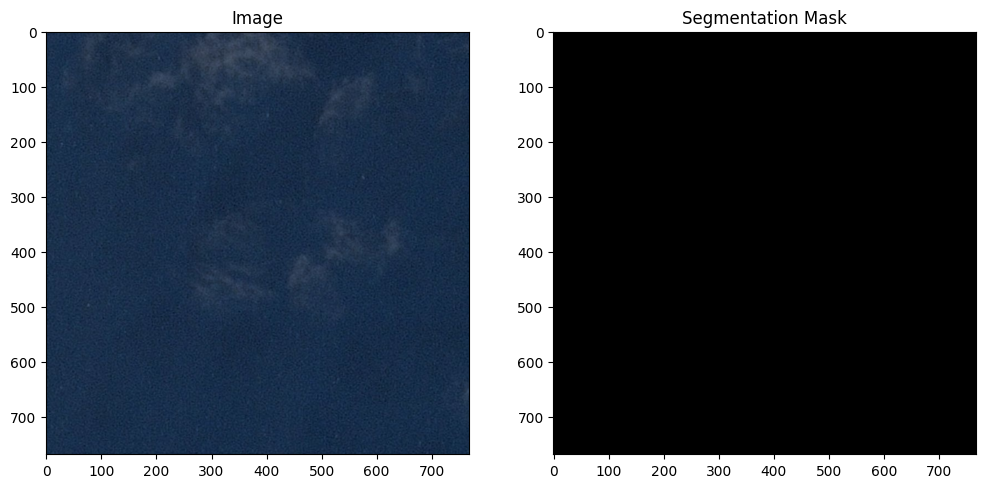

In [49]:
display_image_mask(mask, mask["ImageId"].iloc[0])

Example with ship.

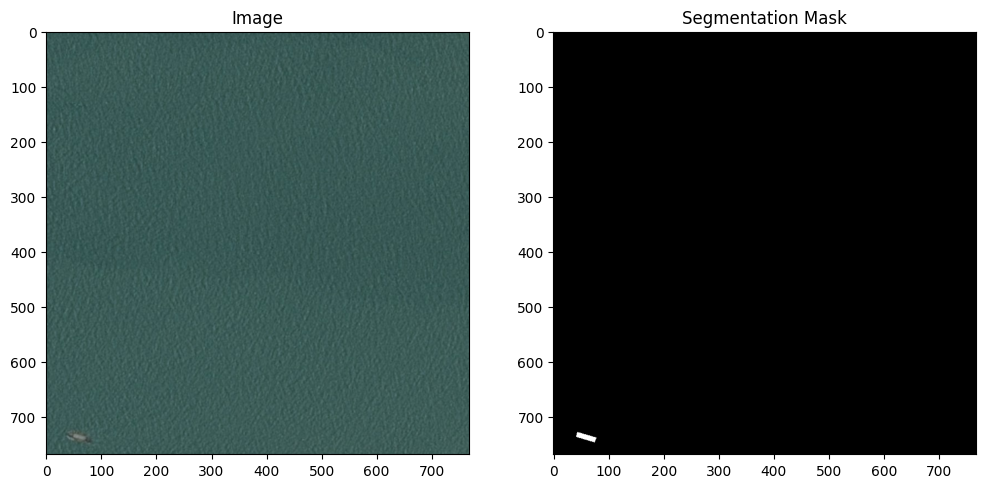

In [50]:
display_image_mask(new_mask, new_mask["ImageId"].iloc[0])

Example with ships.

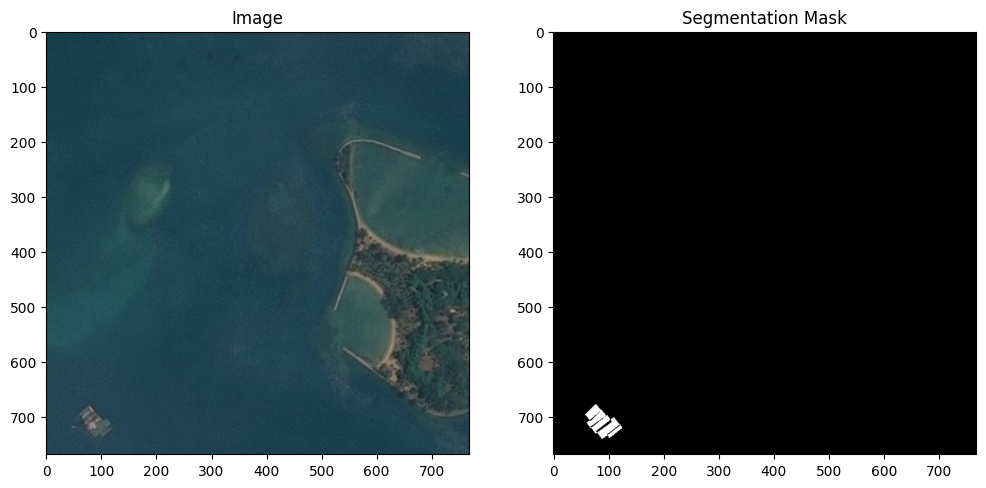

In [51]:
display_image_mask(new_mask, new_mask["ImageId"].iloc[2])

One may also notice that masks are kind of generalized - they are presented in the form of rectangles while true ship forms might differ.